In [15]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap

import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load splitted dataset
with open("splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test, feature_names = pickle.load(f)

In [3]:
# Load the best Random Forest model
with open("rf_best.pkl", "rb") as f:
    rf_best = pickle.load(f)
    
# Predict BMI on main test data
y_pred = rf_best.predict(X_test)

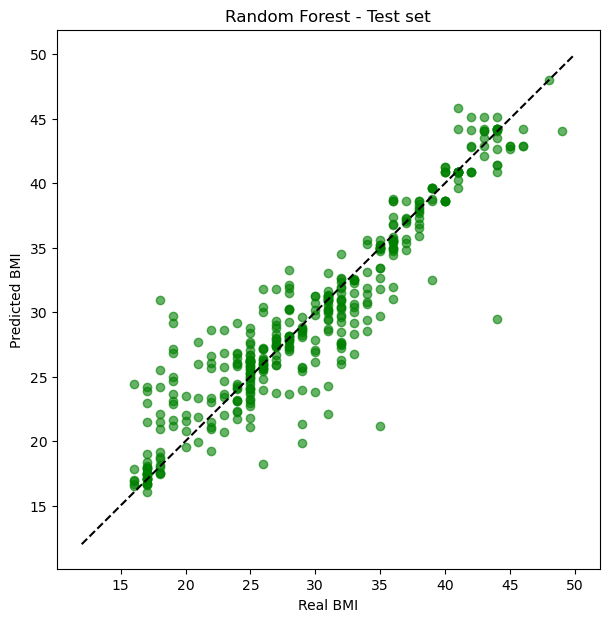

In [4]:
# scatterplot of real vs predicted BMI
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([12,50],[12,50], 'k--') 
plt.title("Random Forest - Test set")
plt.xlabel("Real BMI")
plt.ylabel("Predicted BMI")

plt.show()

Most predicted values are very close to the actual BMI. 
However there are few significant outliers.
Lets compute the biggest error.

In [26]:
# Compute absolute value of prediction difference
errors = np.abs(y_test - y_pred)

# np.argmax funcion returns max value in the axis
idx_max_error = np.argmax(errors)

print("Biggest error:")
print("-------------")
print("Real BMI:", y_test.iloc[idx_max_error])
print("Predicted BMI:", round(y_pred[idx_max_error]))

Biggest error:
-------------
Real BMI: 44
Predicted BMI: 29


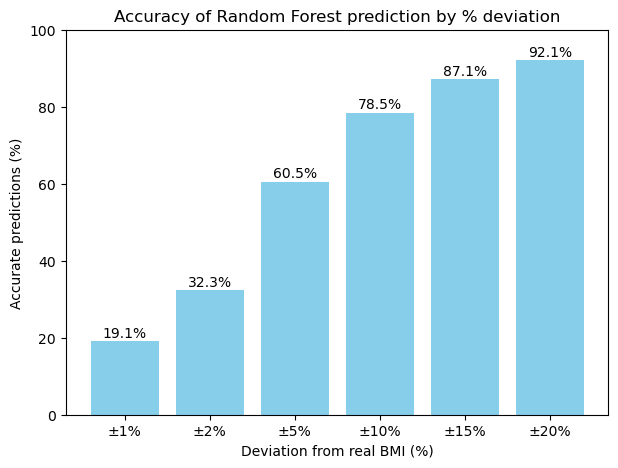

In [6]:
#  computing absolute value of the relative error
relative_error = np.abs(y_test - y_pred) / y_test * 100  

thresholds = [1, 2, 5, 10, 15, 20]  

# For each threshold, compute the percentage of predictions within that error
# This gives the cumulative accuracy curve
accuracy = [(relative_error <= t).mean() * 100 for t in thresholds]

# Plot the cumulative barplot
plt.figure(figsize=(7,5))
plt.bar([f"±{t}%" for t in thresholds], accuracy, color='skyblue')
plt.ylabel("Accurate predictions (%)")
plt.xlabel("Deviation from real BMI (%)")
plt.title("Accuracy of Random Forest prediction by % deviation")
plt.ylim(0,100)
for i, val in enumerate(accuracy):
    plt.text(i, val+1, f"{val:.1f}%", ha='center')
    
plt.show()

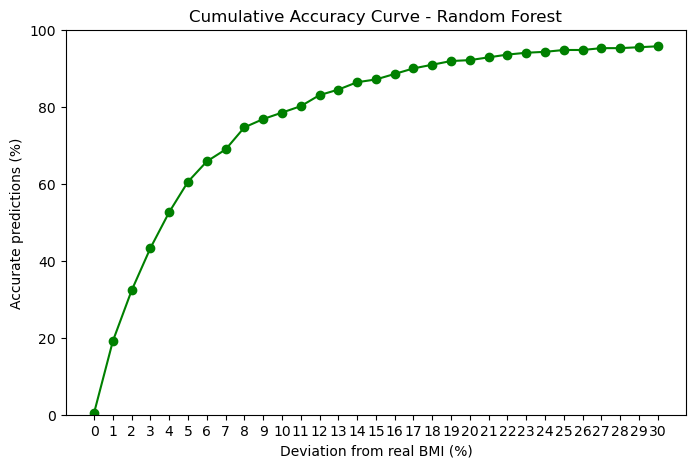

In [7]:
# Computing absolute value of the relative error
relative_error = np.abs(y_test - y_pred) / y_test * 100

# Define a range of error thresholds from 0% to 30%
thresholds = np.arange(0, 31, 1)  

# For each threshold, compute the percentage of predictions within that error
# This gives the cumulative accuracy curve
accuracy = [(relative_error <= t).mean() * 100 for t in thresholds]

# Plot the cumulative accuracy curve
plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracy, marker='o', color='green')
plt.title("Cumulative Accuracy Curve - Random Forest")
plt.xlabel("Deviation from real BMI (%)")
plt.ylabel("Accurate predictions (%)")
plt.xticks(thresholds)
plt.ylim(0,100)
plt.show()

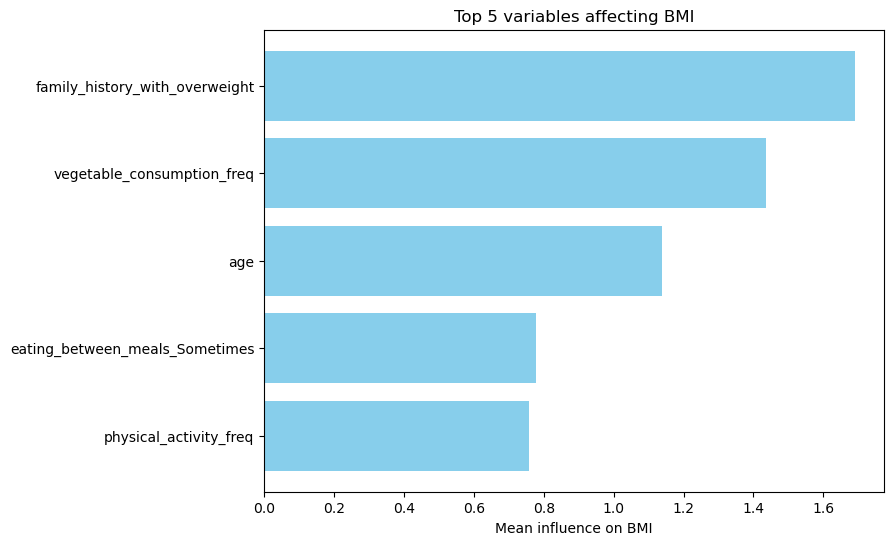

In [24]:
# Randomly sample 100 instances from the test set to speed up SHAP computation
idx = np.random.choice(X_test_scaled.shape[0], 100, replace=False)
X_sample = X_test_scaled[idx]

# Initialize the SHAP TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the sampled test data
shap_values = explainer.shap_values(X_sample)

# Compute the mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": shap_importance
}).sort_values("importance", ascending=False)

# Plot SHAP summary barplot
plt.figure(figsize=(8,6))
plt.barh(importance_df["feature"][:5][::-1], importance_df["importance"][:5][::-1], color="skyblue")
plt.xlabel("Mean influence on BMI")
plt.title("Top 5 variables affecting BMI")
plt.show()

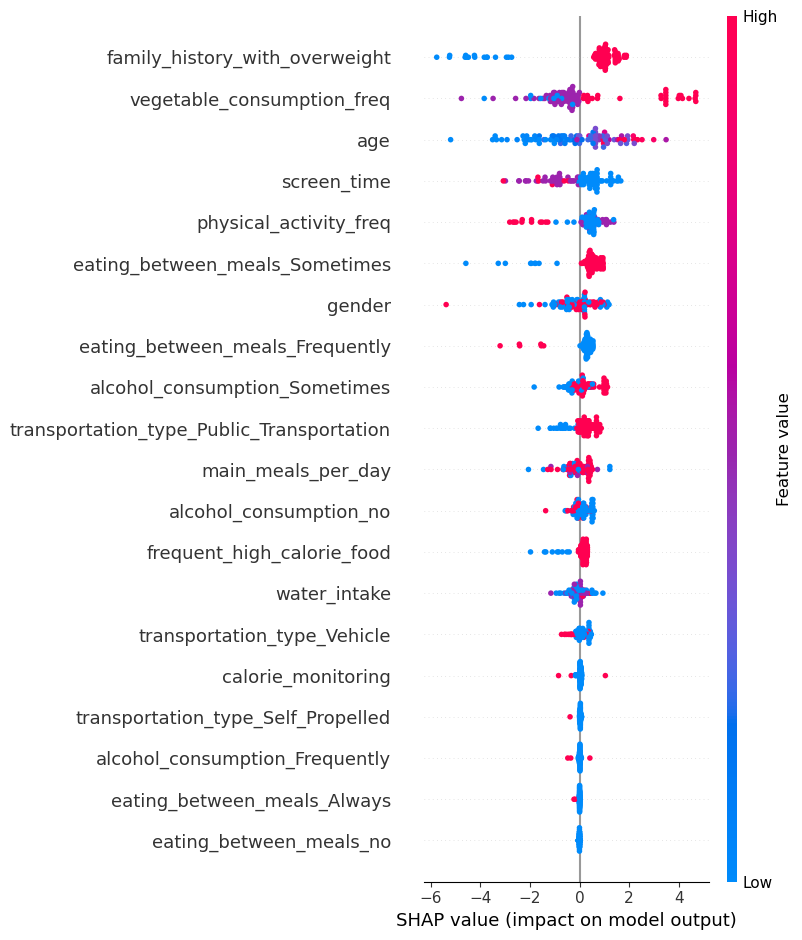

In [23]:
# Extract the trained RandomForestRegressor model from the pipeline
rf_model = rf_best.named_steps['randomforestregressor']

# Scale the test data using the fitted StandardScaler
X_test_scaled = rf_best.named_steps['standardscaler'].transform(X_test)

# Randomly sample 100 instances from the test set to speed up SHAP computation
idx = np.random.choice(X_test_scaled.shape[0], 100, replace=False)
X_sample = X_test_scaled[idx]

# Initialize the SHAP TreeExplainer for the Random Forest model
# 'tree_path_dependent' is usually best for tree-based models
explainer = shap.TreeExplainer(
    rf_model, 
    feature_perturbation="tree_path_dependent"
)

# Compute SHAP values for the sampled test data
shap_values = explainer.shap_values(X_sample)

# Plot the SHAP summary plot to visualize feature importance and impact
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
)

**How to read SHAP plot:**

- family_history_with_overweight variable has biggest impact on model prediction
- Red color indicates family has history of overweight
- Blue color indicates family doesn't have history of overweight   
- Red dots on the right → having family history with overweight increases predicted BMI.  
- Blue dots on the left → not having family history with overweight decreases predicted BMI.  
